# Autoencoders para Detecção de Fraudes

**Autor**: Matheus Jericó Palhares <br>
**LinkedIn**: https://linkedin.com/in/matheusjerico

**Referências:**

https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

### Dataset - Credit Card Fraud Detection
**Link**:<br> https://www.kaggle.com/mlg-ulb/creditcardfraud

**Contexto**: <br>
É de extrema importância que as empresas identifiquem e reconheçam transações fraudulentas com cartão de crédito, para que os clientes não sejam cobrados pelos itens que não compraram e as empresas não tomem prejuízo devido à fraude.

**Conteúdo**:<br>
O dataset contém transações realizadas com cartões de crédito em setembro de 2013 por portadores de cartões europeus. Este conjunto de dados apresenta transações que ocorreram em dois dias, nas quais temos 492 fraudes em 284.807 transações. O conjunto de dados é altamente desequilibrado, a classe positiva (fraudes) representa 0,172% de todas as transações.<br>

O dataset contém apenas variáveis de entrada numéricas que são o resultado de uma transformação PCA. Infelizmente, devido a problemas de confidencialidade, não é possível utilizar os recursos originais e mais informações básicas sobre os dados. Features de V1, V2, até V28 são os principais componentes obtidos com o PCA, os únicos recursos que não foram transformados com o PCA são 'Tempo' e 'Valor'. O recurso 'Tempo' contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. O recurso 'Valor' é o valor da transação, esse recurso pode ser usado para aprendizado sensível a custos dependente de exemplo. O recurso 'Classe' é a variável de resposta e assume o valor 1 em caso de fraude e 0 em caso contrário.

**Resolução**: <br>

Para resolução do problema, utilizamos Autoendoder, que é uma técnica de aprendizado não supervisionado de Deep Learning, para realizar redução de dimensionalidade e identificar valores extremos.

A framework Keras foi o escolhido para usar na implementação do modelo de rede neural utilizado pelo Autoencoder.

## 1. Importar Bibliotecas

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Carregar dados

In [0]:
dataset = pd.read_csv("/content/drive/My Drive/Estudos/Inteligência Artificial - PÓS/AprendizadoNaoSupervisionado/Dataset/creditcard.csv")

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- Dataset não possui valores nulos em suas colunas.

In [0]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- Dataset apresenta quantidade significativa de outliers na maioria de suas colunas.

## 3. Análise Exploratória

### 3.1. Distribuição dos Dados com base na Classe


In [0]:
print("Distribuição das classificações dos dados:")
print(f"Transações Não Fraudulentas: {round(dataset['Class'].value_counts()[0]/len(dataset) * 100,2)}%.")
print(f"Transações Fraudulentas: {round(dataset['Class'].value_counts()[1]/len(dataset) * 100,2)}%.")

Distribuição das classificações dos dados:
Transações Não Fraudulentas: 99.83%.
Transações Fraudulentas: 0.17%.


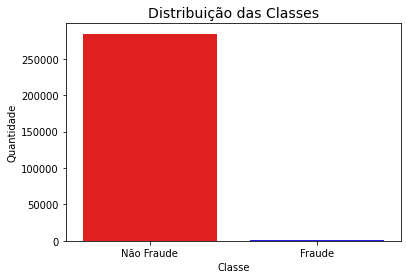

In [0]:
labels = ['Não Fraude', 'Fraude']
sns.countplot('Class', data = dataset, palette = ['red','blue'])
plt.title('Distribuição das Classes', fontsize=14)
plt.xticks(range(2), labels)
plt.xlabel("Classe")
plt.ylabel("Quantidade");

- O dataset é originalmente desbalanceado. A maior parte dos dados são representados por transações não fraudulentas. Tendo em vista que, analisando os dados de uma empresa fictícia, podemos ter grande similaridade na distribuição dos dados de fraude com o apresentado neste dataset.

### 3.2. Existe diferência nos valores das transações fraudulentas e não fraudulentas?

In [0]:
fraude = dataset[dataset['Class'] == 1]['Amount']
n_fraude= dataset[dataset['Class'] == 0]['Amount']

In [0]:
print(f"Transações Não Fraudulentas:\n{n_fraude.describe()}")
print()
print(f"Transações Fraudulentas:\n{fraude.describe()}")

Transações Não Fraudulentas:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Transações Fraudulentas:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


- As transações não fraudulentas possuem uma gama de valores de transação muito maior do que as transações fraudulentas.
- Também é possível observar que as transações com maiores valores são classificadas como não fraudulentas.

### 3.3. Distribuição das Transações

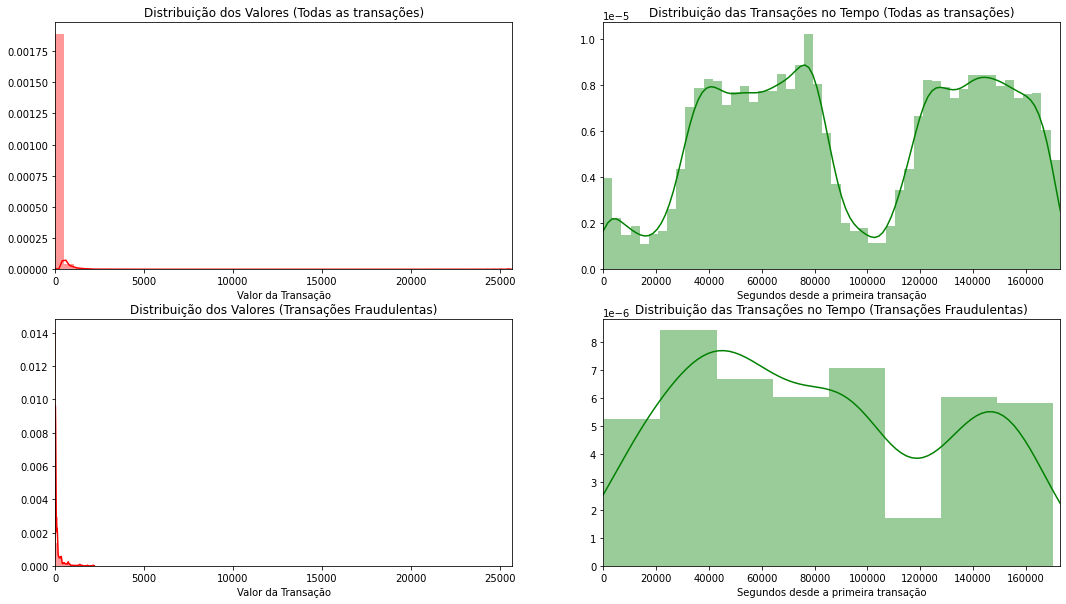

In [0]:
fig, ax = plt.subplots(2, 2, figsize = (18,10))

# Dados de todas as transações
valores = dataset['Amount'].values
tempo = dataset['Time'].values

sns.distplot(valores, ax = ax[0][0], color = 'red')
ax[0][0].set_title('Distribuição dos Valores (Todas as transações)', fontsize = 12)
ax[0][0].set_xlim([min(valores), max(valores)])
ax[0][0].set_xlabel('Valor da Transação')

sns.distplot(tempo, ax = ax[0][1], color = 'green')
ax[0][1].set_title('Distribuição das Transações no Tempo (Todas as transações)', fontsize = 12)
ax[0][1].set_xlim([min(tempo), max(tempo)])
ax[0][1].set_xlabel('Segundos desde a primeira transação')

# Dados apenas das transações fraudulentas
valores_fraude = dataset[dataset['Class'] == 1]['Amount'].values
tempo_fraude = dataset[dataset['Class'] == 1]['Time'].values

sns.distplot(valores_fraude, ax = ax[1][0], color = 'red')
ax[1][0].set_title('Distribuição dos Valores (Transações Fraudulentas)', fontsize = 12)
ax[1][0].set_xlim([min(valores), max(valores)])
ax[1][0].set_xlabel('Valor da Transação')

sns.distplot(tempo_fraude, ax = ax[1][1], color = 'green')
ax[1][1].set_title('Distribuição das Transações no Tempo (Transações Fraudulentas)', fontsize = 12)
ax[1][1].set_xlim([min(tempo), max(tempo)])
ax[1][1].set_xlabel('Segundos desde a primeira transação')

plt.show()

- É possível observar que não há uma grande diferença na distribuição dos valores das transações e no horário delas entre as fraudulentas e a totalidade de transações.


## 4. Processamento dos dados

### 4.1. Aplicar técnica de padronização na feature 'Amount'.
- Aplicamos a técnica pois a feature apresenta uma gama grande de valores.

In [0]:
# Remoção da coluna relacionada ao tempo
df = dataset.drop(['Time'], axis=1)

# Normalização da coluna relacionada ao valor da transação
sc = StandardScaler()
df['Amount'] = sc.fit_transform(df['Amount'].values.reshape(-1, 1))

### 4.2. Separar os dados normais dos dados fraudulentos.

In [0]:
# Separação das classes de dados
fraud_data = df[df['Class'] == 1]
n_fraud_data = df[df['Class'] == 0]

### 4.3. Separar dados de Treino e Teste.

In [0]:
# Separação dos dados de treino e de teste
X_train, X_test = train_test_split(n_fraud_data, test_size = 0.2)

X_train = X_train.drop(columns = ['Class']).copy()

X_test_full = pd.concat([X_test, fraud_data], ignore_index=True, sort=False)
X_test_full = shuffle(X_test_full)

y_test = X_test_full['Class'].copy()
X_test = X_test_full.drop(columns = ['Class'])

print('Dimensionalidade dos dados:')
print(f'Treinamento: {X_train.shape}')
print(f'Teste (Fraudulentos): {fraud_data.shape}, Teste (Não Fraudulentos): {X_test.shape}')

Dimensionalidade dos dados:
Treinamento: (227452, 29)
Teste (Fraudulentos): (492, 30), Teste (Não Fraudulentos): (57355, 29)


## 5. Autoencoder

### 5.1. Introdução

Para o treinamento do Autoencoder são utilizados apenas os dados referentes às transações não fraudulentas. Durante o treinamento, o codificador verá milhões de transações não fraudulentas com cartão de crédito.

Dessa forma, o Autoencoder codifica as informações mais relevantes dos dados não fraudulentos. Intuitivamente, podemos dizer que dessa maneira o algoritimo aprende apenas o que é uma transação de cartão de crédito absolutamente normal.

E esse conceito aprendido de uma transação normal com cartão de crédito pode ser encontrado como a representação latente na camada intermediária, usada para recriar os recursos originais usados como dados de entrada para o Autoencoder.

Após o treinamento com os dados não fraudulentos, podemos finalmente usar o Auto Encoder para detectar as anomalias (fraudes).

Com isso, é possível mostrar para o Auto Encoder os dados de ambos os tipos - anomalias e dados normais. Como antes, os recursos de entrada são codificados pelo Autoencoder em uma representação latente que é usada para reconstruir a entrada. Os dados de fraude vãão possuir um erro de reconstruçãão muito superior aos dados normais, pois o Auto Encoder aprendeu a codificar dados de transaçõões normais.


**OBS:**

Caso o Autoencoder seja treinado corretamente, esperamos que o erro entre a saída e a entrada seja muito pequeno para dados normais.

Entretanto, esse não é o caso das anomalias ou, no nosso caso, transações fraudulentas de dados.

Durante o treinamento o codificador automático aprendeu apenas os conceitos e características da instância normal de dados. Isso significa que os pesos do Autoencoder foram ajustados apenas para codificar e reconstruir dados normais (transações não fraudulentas).

Se tentarmos codificar uma transação fraudulenta, a representação latente dessa transação seria significativamente diferente da representação latente de uma transação normal.

Como resultado direto, a entrada reconstruída diferiria ainda mais da entrada original, resultando em um erro muito maior do que no caso de transações normais.

O conhecimento do fato de que dados de entrada fraudulentos resultam em valores de perda mais altos da função de perda de erro quadrático médio (MSE - *Mean Squared Error*) pode ser usado ao nosso favor. Tudo o que precisamos fazer é encontrar um limite de perda que distinga os dados normais dos fraudulentos (*threshold*).

Na prática, isso significa que instâncias de dados para as quais obtemos um valor de perda acima desse limite classificam essa instância como uma transação fraudulenta.

Por outro lado, instâncias de dados com valores de perda abaixo desse limite podem ser consideradas dados normais ou transações não fraudulentas.

    Caso 1: O valor da perda MSE para um recurso de entrada está acima do limiar de perda → o recurso de entrada é uma transação fraudulenta
    Caso 2: O valor da perda MSE para um recurso de entrada está abaixo do limite → o recurso de entrada é uma transação não fraudulenta




### 5.2. Construção do Auto Encoder utilizando o framework Keras


In [0]:
# Dimensões dos dados de entrada
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))

# Camadas de encoding
encoder = Dense(18, activation="relu")(input_layer)
encoder = Dense(14, activation="relu", activity_regularizer=regularizers.l2(10e-5))(encoder) 
encoder = Dense(10, activation="relu")(encoder)

# Camadas de decoding
decoder = Dense(14, activation='relu')(encoder)
decoder = Dense(18, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="./model/model.h5", verbose=0, save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

### 5.3. Sumário da Rede Neural

In [0]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 18)                540       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                266       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                154       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                270       
_________________________________________________________________
dense_5 (Dense)              (None, 29)                551   

### 5.4. Treinamento do Auto Encoder

In [0]:
# Treinamento da rede utilizando 15 Épocas e um tamanho de batch de 32

EPOCHS = 15
BS = 32

history = autoencoder.fit(X_train, X_train,
                          epochs = EPOCHS, 
                          batch_size = BS,      
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1).history

Epoch 1/2
7108/7108 [==============================] - 13s 2ms/step - loss: 0.8347 - accuracy: 0.5223 - val_loss: 0.9868 - val_accuracy: 0.5813
Epoch 2/2
7108/7108 [==============================] - 13s 2ms/step - loss: 0.7929 - accuracy: 0.5973 - val_loss: 0.9667 - val_accuracy: 0.5995


- Carregar o modelo foi salvo no diretório ```/model```

In [ ]:
autoencoder = load_model('model.h5')

### 5.5. Gráfico de Erro de Validação do Modelo

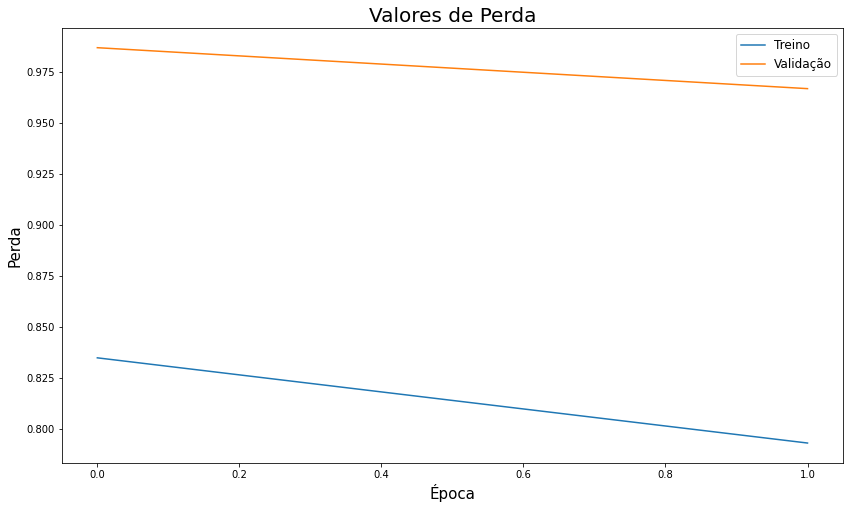

In [0]:
# Representação gráfica dos valores de perda para os dados de Treino e de Validação ao longo do treinamento
fig, ax = plt.subplots(figsize=[14,8])
ax.plot(history['loss'], label='Treino')
ax.plot(history['val_loss'], label='Validação')
ax.set_title('Valores de Perda', fontdict={'fontsize': 20})
ax.set_ylabel('Perda', fontdict={'fontsize': 15})
ax.set_xlabel('Época', fontdict={'fontsize': 15})
ax.legend(fontsize=12, loc='upper right');

In [0]:
predictions = autoencoder.predict(X_test)

## 6. Predição

### 6.1. Demonstração dos erros de reconstrução nos dados de Teste

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [0]:
error_df.describe()

,reconstruction_error,true_class
count,57355.000000,57355.000000
mean,0.965397,0.008578
std,4.935987,0.092221
min,0.053520,0.000000
25%,0.276356,0.000000
50%,0.434653,0.000000
75%,0.683521,0.000000
max,263.731904,1.000000


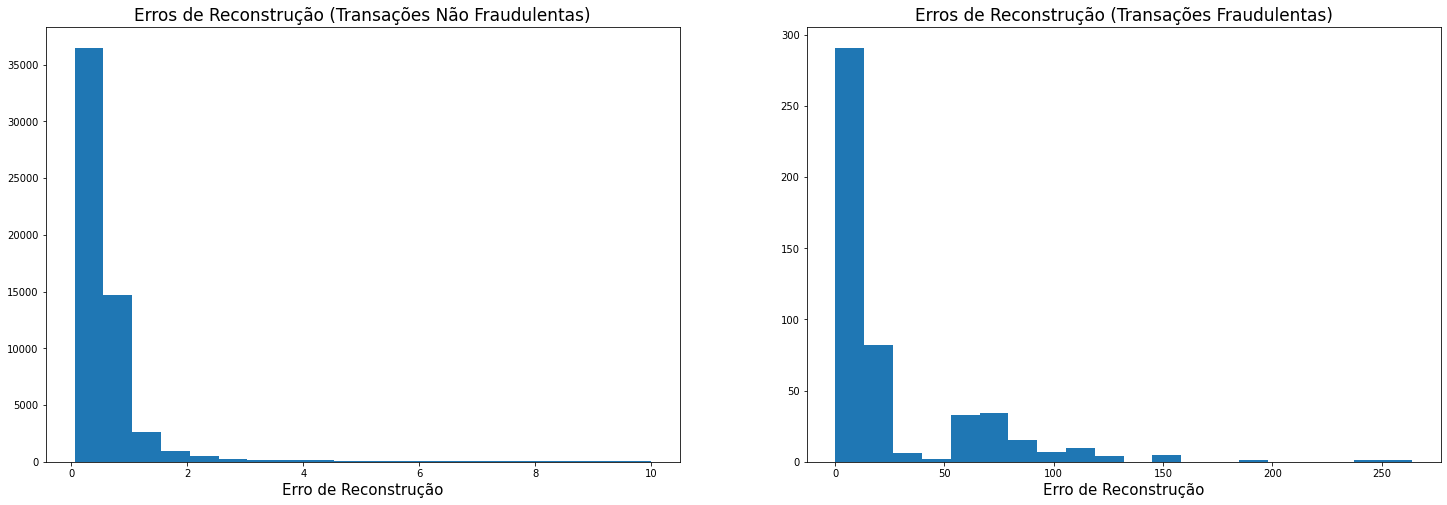

In [0]:
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
fraud_error_df = error_df[error_df['true_class'] == 1]

fig, ax = plt.subplots(1, 2, figsize = (25,8))
bins=20

ax[0].hist(normal_error_df.reconstruction_error.values, bins=bins)
ax[0].set_title('Erros de Reconstrução (Transações Não Fraudulentas)', fontsize = 17)
ax[0].set_xlabel('Erro de Reconstrução', fontsize = 15)

ax[1].hist(fraud_error_df.reconstruction_error.values, bins=bins)
ax[1].set_title('Erros de Reconstrução (Transações Fraudulentas)', fontsize = 17)
_ = ax[1].set_xlabel('Erro de Reconstrução', fontsize = 15)

- Os erros de reconstrução, em sua maioria, são valores baixos, visto que representam as transações não fraudulentas. Já a grande parte dos erros mais altos é representativa das transações fraudulentas.
- Para a definição de melhor valor limite para diferenciar as transações fraudulentas das não fraudulentas, é preciso utilizar algumas métricas.

## 7. Métricas

### 7.1 Precisão vs Revocação (Recall)

<img width="303" height="604" src="https://upload.wikimedia.org/wikipedia/commons/a/ab/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o.png" />

Precisão e Recall são definidos das seguintes maneiras:

$$\text{Precisão} = \frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos} + \text{falsos positivos}}$$

$$\text{Revocação} = \frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos} + \text{falsos negativos}}$$

**Precisão** (também chamada de valor preditivo positivo) é a fração de instâncias recuperadas que são relevantes.

**Revocação** (também conhecida como sensibilidade) é a fração de instâncias relevantes que são recuperadas. 

Tanto precisão quanto revocação são, portanto, bases para o estudo e compreensão da medida de relevância.

Alto recall, mas baixa precisão significa muitos resultados, a maioria dos quais tem pouca ou nenhuma relevância. Quando a precisão é alta, mas o recall é baixo, temos o oposto - poucos resultados retornados com uma relevância muito alta. Normalmente, o resultado ideal seria ter uma alta precisão e alto recall.

### 7.2 F1 Score

F1 Score é uma medida que combina precisão e revocação é a média harmónica entre precisão e revocação

$${\displaystyle F1=2\cdot {\frac {\mathrm {precisão} \cdot \mathrm {revocação} }{\mathrm {precisão} +\mathrm {revocação} }}}$$

Esta medida é aproximadamente a média de ambas quando seus valores estão próximos, e de maneira mais geral, o quadrado da média geométrica dividido pela média aritmética. Há várias razões pelas quais o F1 Score pode ser criticado em casos específicos devido ao seu viés como métrica de avaliação.

**Fonte**: https://pt.wikipedia.org/wiki/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o

### 7.3 Comparação das métricas para o modelo gerado

In [0]:
# Cálculo das curvas de precisão e revocação
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

# Cálculo da curva do F1 Score
F1_score=[]
F1_score = 2 * (precision * recall) / (precision + recall)
threshold_max_f1 = th[np.argmax(F1_score)]

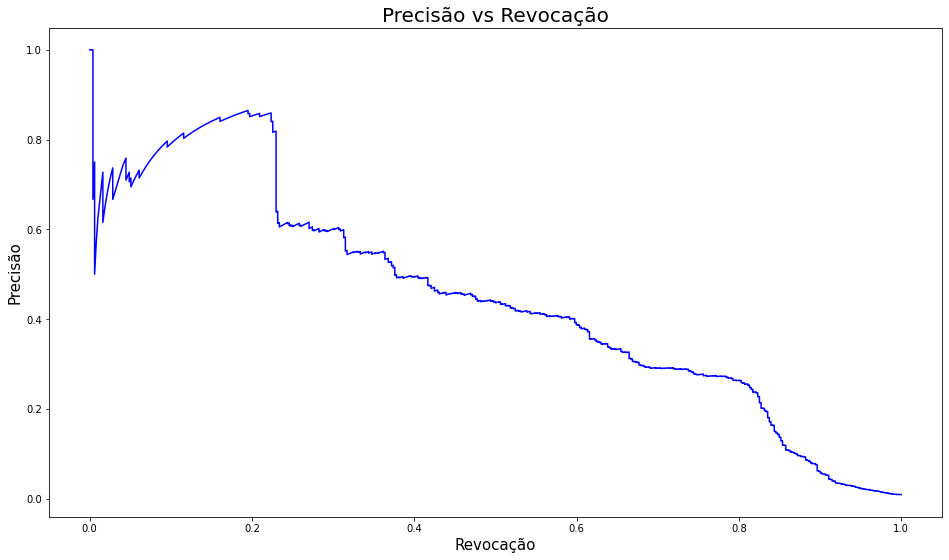

In [0]:
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(recall, precision, 'b', label='Precision-Recall curve')
ax.set_title('Precisão vs Revocação', fontsize=20)
ax.set_xlabel('Revocação', fontsize=15)
_ = ax.set_ylabel('Precisão', fontsize=15)

Uma área alta sob a curva representa alta revocação e alta precisão, onde alta precisão se refere a uma baixa taxa de falsos positivos e alta revocação se refere a uma baixa taxa de falsos negativos. As pontuações altas de ambos mostram que o classificador está retornando resultados precisos (alta precisão), além de retornar a maioria de todos os resultados positivos (alta revocação).

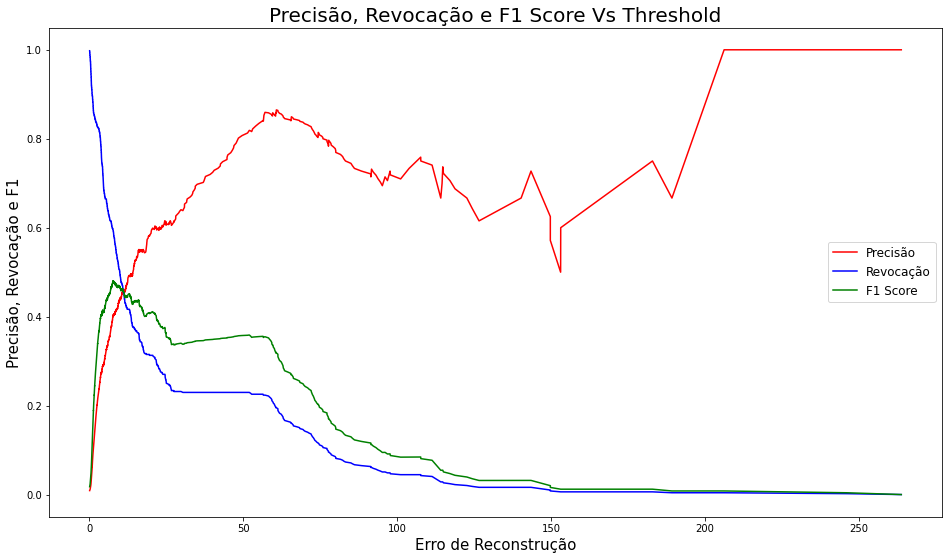

In [0]:
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(th, precision[1:], 'r', label='Precisão')
ax.plot(th, recall[1:], 'b', label='Revocação')
ax.plot(th, F1_score[1:], 'g', label='F1 Score')

ax.set_title('Precisão, Revocação e F1 Score Vs Threshold', fontsize=20)
ax.set_xlabel('Erro de Reconstrução', fontsize=15)
ax.set_ylabel('Precisão, Revocação e F1', fontsize=15)
_ = ax.legend(fontsize=12)

É possível observar que, à medida que o erro de reconstrução aumenta, nossa precisão também aumenta.

Já na para a revocação temos a situação exatamente oposta. À medida que o erro de reconstrução aumenta, a revocação diminui. O mesmo acontece com o valor de F1 Score.

In [0]:
print('Valor máximo de  F1 Score: ', str(max(F1_score)))

Valor máximo de  F1 Score:  0.4805945499587118


In [0]:
def plot_reconstruction_error(error_df, threshold):
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots(figsize=(16, 9))

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraude" if name == 1 else "Normal")
        
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Limite')
    ax.set_title("Erros de reconstrução para as diferentes transações", fontsize=20)
    ax.set_ylabel("Erro de Reconstrução", fontsize=15)
    ax.set_xlabel("Índice dos dados", fontsize=15)
    ax.legend(fontsize=12)

In [0]:
def plot_confusion_matrix(error_df, threshold):
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)

    fig, ax = plt.subplots(figsize=(16, 9))

    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    ax.set_title("Matriz de Confusão", fontsize=20)
    ax.set_ylabel('Classe Verdadeira', fontsize=15)
    ax.set_xlabel('Classe Predita', fontsize=15)

    return y_pred

#### Valor balanceado entre Precisão e Revocação

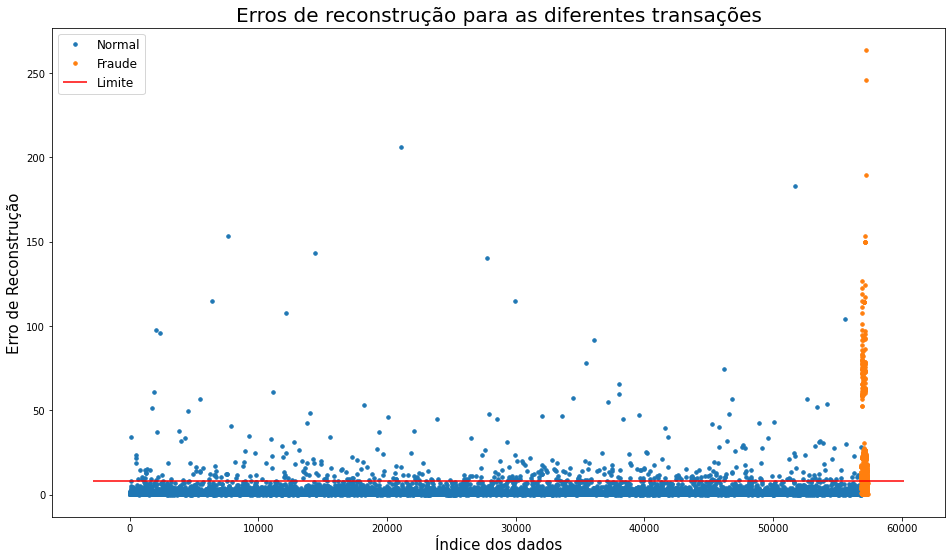

In [0]:
plot_reconstruction_error(error_df, threshold_max_f1)

### 7.3. Matriz de Confusão
- O valor de Threshold utilizado foi o valor que representa o maior resultado para a métrica de F1-Score.


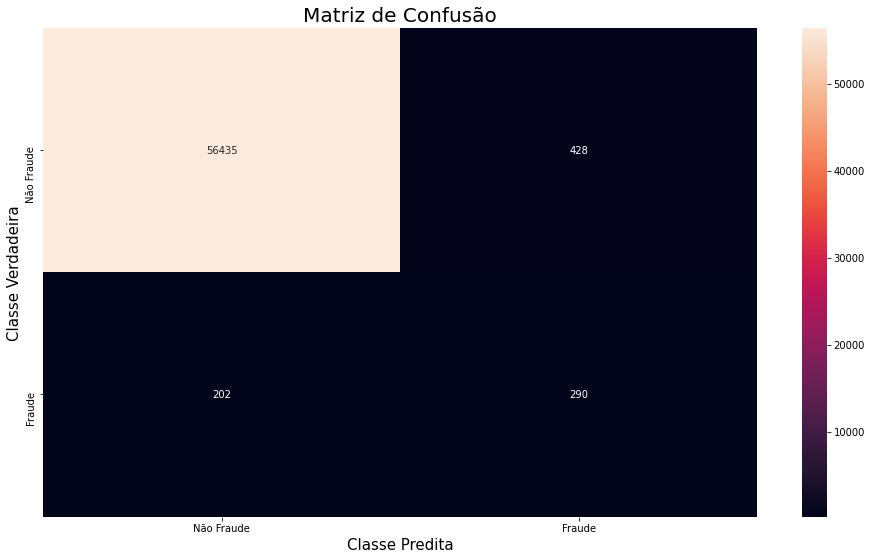

In [0]:
y_pred = plot_confusion_matrix(error_df, threshold_max_f1)

In [0]:
print(classification_report(error_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.40      0.59      0.48       492

    accuracy                           0.99     57355
   macro avg       0.70      0.79      0.74     57355
weighted avg       0.99      0.99      0.99     57355



#### AJUSTE FINO: Otimizando valor de Threshold para melhor resultado de Revocação
- O objetivo é minimizar o falso negativo, o caso de ser uma transaçãão fraudulenta e o algoritmo predizer que é uma transaçãão normal.

In [0]:
threshold = 3.2

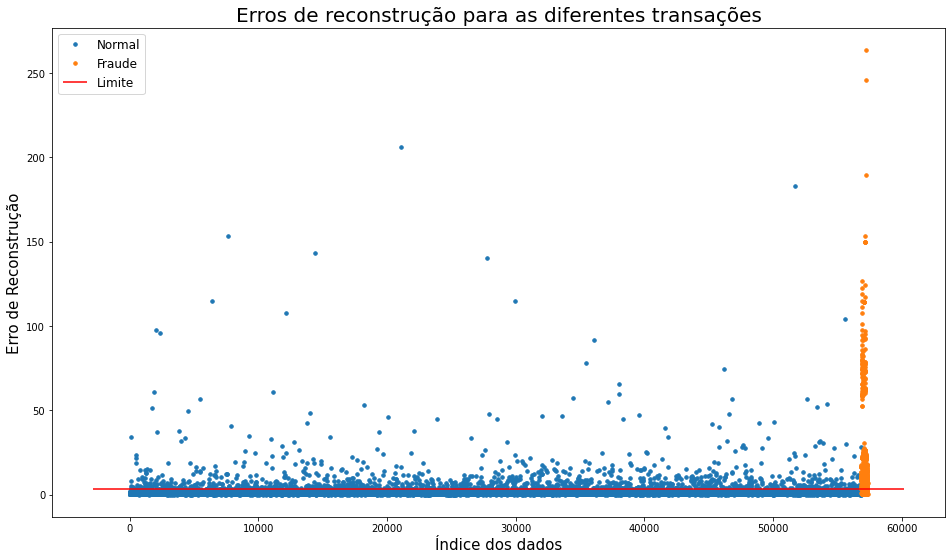

In [0]:
plot_reconstruction_error(error_df, threshold)

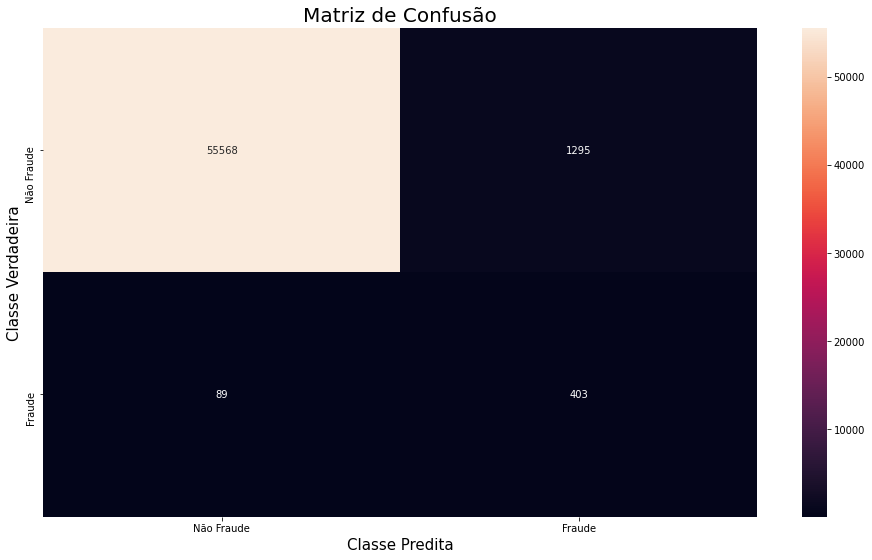

In [0]:
y_pred = plot_confusion_matrix(error_df, threshold)

In [0]:
print(classification_report(error_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.24      0.82      0.37       492

    accuracy                           0.98     57355
   macro avg       0.62      0.90      0.68     57355
weighted avg       0.99      0.98      0.98     57355

